# This is a tutorial of using spaMultiVAE for the spatial multi-omics DBiT-seq data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaMultiVAE import SPAMULTIVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Multiomics_DBiT_seq_0713_data.h5'
        self.select_genes = 0
        self.select_proteins = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.gene_noise = 0
        self.protein_noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.gene_decoder_layers = [32, 64]
        self.protein_decoder_layers = [32, 32]
        self.beta = 20
        self.num_samples = 1
        self.fix_inducing_points = True
        self.inducing_point_steps = 15
        self.fixed_gp_params = False
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.gene_denoised_counts_file = "gene_denoised_counts.txt"
        self.protein_denoised_counts_file = "protein_denoised_counts.txt"
        self.protein_sigmoid_file = "protein_sigmoid.txt"
        self.gene_enhanced_denoised_counts_file = "gene_enhanced_denoised_counts.txt"
        self.protein_enhanced_denoised_counts_file = "protein_enhanced_denoised_counts.txt"
        self.enhanced_loc_file = "enhanced_loc.txt"
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrices, initial protein background priors, and build the spaMultiVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x1 = np.array(data_mat['X_gene_SVG']).astype('float64')
x2 = np.array(data_mat['X_protein']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x1, n=args.select_genes, plot=False)
    x1 = x1[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

if args.select_proteins > 0:
    importantProteins = geneSelection(x2, n=args.select_proteins, plot=False)
    x2 = x2[:, importantProteins]
    np.savetxt("selected_proteins.txt", importantProteins, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x1.shape)
print(x2.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

adata1 = sc.AnnData(x1, dtype="float64")
adata1 = normalize(adata1,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

adata2 = sc.AnnData(x2, dtype="float64")
adata2 = normalize(adata2,
                  size_factors=False,
                  normalize_input=True,
                  logtrans_input=True)

adata2_no_scale = sc.AnnData(x2, dtype="float64")
adata2_no_scale = normalize(adata2_no_scale,
                  size_factors=False,
                  normalize_input=False,
                  logtrans_input=True)

# Fit GMM model to the protein counts and use the smaller component as the initial values as protein background prior
gm = GaussianMixture(n_components=2, covariance_type="diag", n_init=20).fit(adata2_no_scale.X)
back_idx = np.argmin(gm.means_, axis=0)
protein_log_back_mean = np.log(np.expm1(gm.means_[back_idx, np.arange(adata2_no_scale.n_vars)]))
protein_log_back_scale = np.sqrt(gm.covariances_[back_idx, np.arange(adata2_no_scale.n_vars)])
print("protein_back_mean shape", protein_log_back_mean.shape)

model = SPAMULTIVAE(gene_dim=adata1.n_vars, protein_dim=adata2.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, 
    gene_decoder_layers=args.gene_decoder_layers, protein_decoder_layers=args.protein_decoder_layers,
    gene_noise=args.gene_noise, protein_noise=args.protein_noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata1.n_obs, beta=args.beta, 
    protein_back_mean=protein_log_back_mean, protein_back_scale=protein_log_back_scale, dtype=torch.float64, 
    device=args.device)

print(str(model))

(1789, 254)
(1789, 22)
(1789, 2)
(256, 2)
protein_back_mean shape (22,)
SPAMULTIVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=276, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (gene_decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum

Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, gene_ncounts=adata1.X, gene_raw_counts=adata1.raw.X, gene_size_factors=adata1.obs.size_factors, 
            protein_ncounts=adata2.X, protein_raw_counts=adata2.raw.X,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

Training
Training epoch 1, ELBO:1418.59001558, Gene NB loss:1.18487078, Protein NB mixture loss:45.45685764, Protein background KL:24.28652131, KLD loss:0.02502102, noise regularization:0.000000
Current kernel scale tensor([19.9992])
Training epoch 2, ELBO:1346.46926070, Gene NB loss:1.16121831, Protein NB mixture loss:42.63275209, Protein background KL:23.52811114, KLD loss:0.02762999, noise regularization:0.000000
Current kernel scale tensor([19.9962])
Training epoch 3, ELBO:1313.10353566, Gene NB loss:1.14457116, Protein NB mixture loss:41.64140709, Protein background KL:22.86761322, KLD loss:0.03170637, noise regularization:0.000000
Current kernel scale tensor([19.9928])
Training epoch 4, ELBO:1285.05107099, Gene NB loss:1.13028150, Protein NB mixture loss:40.83636662, Protein background KL:22.28414423, KLD loss:0.03522397, noise regularization:0.000000
Current kernel scale tensor([19.9892])
Training epoch 5, ELBO:1235.28935442, Gene NB loss:1.11361955, Protein NB mixture loss:38.9

Training epoch 38, ELBO:394.95540278, Gene NB loss:0.86681967, Protein NB mixture loss:11.79126067, Protein background KL:7.08512087, KLD loss:0.09137867, noise regularization:0.000000
Current kernel scale tensor([19.9044])
Training epoch 39, ELBO:381.66237764, Gene NB loss:0.86883368, Protein NB mixture loss:11.41746472, Protein background KL:6.79239689, KLD loss:0.08847198, noise regularization:0.000000
Current kernel scale tensor([19.9041])
Training epoch 40, ELBO:366.30261529, Gene NB loss:0.86625608, Protein NB mixture loss:10.95435242, Protein background KL:6.48991652, KLD loss:0.09211487, noise regularization:0.000000
Current kernel scale tensor([19.9036])
Training epoch 41, ELBO:354.59565151, Gene NB loss:0.86860023, Protein NB mixture loss:10.65447432, Protein background KL:6.20204686, KLD loss:0.09322347, noise regularization:0.000000
Current kernel scale tensor([19.9033])
Training epoch 42, ELBO:339.90541895, Gene NB loss:0.86703546, Protein NB mixture loss:10.22230728, Prot

Training epoch 75, ELBO:156.07254074, Gene NB loss:0.85897482, Protein NB mixture loss:5.75932952, Protein background KL:1.17946370, KLD loss:0.11717983, noise regularization:0.000000
Current kernel scale tensor([19.8886])
Training epoch 76, ELBO:154.59823112, Gene NB loss:0.85845601, Protein NB mixture loss:5.73506310, Protein background KL:1.13075256, KLD loss:0.11279771, noise regularization:0.000000
Current kernel scale tensor([19.8880])
Training epoch 77, ELBO:152.87575176, Gene NB loss:0.85668941, Protein NB mixture loss:5.71234634, Protein background KL:1.06893140, KLD loss:0.11640870, noise regularization:0.000000
Current kernel scale tensor([19.8873])
Training epoch 78, ELBO:151.34688069, Gene NB loss:0.86082720, Protein NB mixture loss:5.67426652, Protein background KL:1.02647904, KLD loss:0.11542526, noise regularization:0.000000
Current kernel scale tensor([19.8866])
Training epoch 79, ELBO:149.84931414, Gene NB loss:0.85974186, Protein NB mixture loss:5.65165714, Protein b

Training epoch 112, ELBO:130.30804927, Gene NB loss:0.85674369, Protein NB mixture loss:5.36878023, Protein background KL:0.28443735, KLD loss:0.10882398, noise regularization:0.000000
Current kernel scale tensor([19.8654])
Training epoch 113, ELBO:130.08773346, Gene NB loss:0.85478863, Protein NB mixture loss:5.36805639, Protein background KL:0.27596290, KLD loss:0.11157511, noise regularization:0.000000
Current kernel scale tensor([19.8648])
Training epoch 114, ELBO:129.61995910, Gene NB loss:0.85314569, Protein NB mixture loss:5.35099586, Protein background KL:0.27138845, KLD loss:0.10935910, noise regularization:0.000000
Current kernel scale tensor([19.8642])
Training epoch 115, ELBO:129.76334239, Gene NB loss:0.85249912, Protein NB mixture loss:5.37002298, Protein background KL:0.26021513, KLD loss:0.10859787, noise regularization:0.000000
Current kernel scale tensor([19.8636])
Training epoch 116, ELBO:129.26674716, Gene NB loss:0.85121903, Protein NB mixture loss:5.35223369, Prot

Training epoch 149, ELBO:126.48674614, Gene NB loss:0.84820720, Protein NB mixture loss:5.33769477, Protein background KL:0.13285572, KLD loss:0.11159246, noise regularization:0.000000
Current kernel scale tensor([19.8423])
Training epoch 150, ELBO:126.50662565, Gene NB loss:0.84647758, Protein NB mixture loss:5.33702136, Protein background KL:0.13625273, KLD loss:0.11159220, noise regularization:0.000000
Current kernel scale tensor([19.8416])
Training epoch 151, ELBO:126.54714571, Gene NB loss:0.85179910, Protein NB mixture loss:5.33971634, Protein background KL:0.13049283, KLD loss:0.10698041, noise regularization:0.000000
Current kernel scale tensor([19.8410])
Training epoch 152, ELBO:126.57697555, Gene NB loss:0.85271267, Protein NB mixture loss:5.34037454, Protein background KL:0.13022901, KLD loss:0.11065114, noise regularization:0.000000
Current kernel scale tensor([19.8403])
Training epoch 153, ELBO:126.43156540, Gene NB loss:0.84703785, Protein NB mixture loss:5.34113407, Prot

Training epoch 186, ELBO:125.39927175, Gene NB loss:0.84790149, Protein NB mixture loss:5.32822847, Protein background KL:0.08870898, KLD loss:0.10249304, noise regularization:0.000000
Current kernel scale tensor([19.8183])
Training epoch 187, ELBO:125.60031818, Gene NB loss:0.84776673, Protein NB mixture loss:5.33709346, Protein background KL:0.08985904, KLD loss:0.10593360, noise regularization:0.000000
Current kernel scale tensor([19.8177])
Training epoch 188, ELBO:125.41397355, Gene NB loss:0.84495426, Protein NB mixture loss:5.33301473, Protein background KL:0.08756226, KLD loss:0.10334875, noise regularization:0.000000
Current kernel scale tensor([19.8171])
Training epoch 189, ELBO:125.14723407, Gene NB loss:0.84402218, Protein NB mixture loss:5.32293450, Protein background KL:0.08520560, KLD loss:0.10398843, noise regularization:0.000000
Current kernel scale tensor([19.8164])
Training epoch 190, ELBO:125.21852018, Gene NB loss:0.84613509, Protein NB mixture loss:5.32248828, Prot

Training epoch 223, ELBO:124.99768374, Gene NB loss:0.84431715, Protein NB mixture loss:5.32639379, Protein background KL:0.07384223, KLD loss:0.10662022, noise regularization:0.000000
Current kernel scale tensor([19.7944])
Training epoch 224, ELBO:124.49956963, Gene NB loss:0.84086829, Protein NB mixture loss:5.31226393, Protein background KL:0.06655930, KLD loss:0.10573904, noise regularization:0.000000
Current kernel scale tensor([19.7937])
Training epoch 225, ELBO:124.83875768, Gene NB loss:0.84635956, Protein NB mixture loss:5.31884253, Protein background KL:0.07154247, KLD loss:0.10386642, noise regularization:0.000000
Current kernel scale tensor([19.7931])
Training epoch 226, ELBO:124.61103606, Gene NB loss:0.84506191, Protein NB mixture loss:5.30849840, Protein background KL:0.07174304, KLD loss:0.10496898, noise regularization:0.000000
Current kernel scale tensor([19.7924])
Training epoch 227, ELBO:124.82222615, Gene NB loss:0.84515067, Protein NB mixture loss:5.32040868, Prot

Training epoch 260, ELBO:124.31966289, Gene NB loss:0.84403885, Protein NB mixture loss:5.30851394, Protein background KL:0.05843190, KLD loss:0.09996906, noise regularization:0.000000
Current kernel scale tensor([19.7699])
Training epoch 261, ELBO:124.01707737, Gene NB loss:0.83943763, Protein NB mixture loss:5.29778016, Protein background KL:0.05874705, KLD loss:0.09778070, noise regularization:0.000000
Current kernel scale tensor([19.7692])
Training epoch 262, ELBO:124.07058054, Gene NB loss:0.84016286, Protein NB mixture loss:5.30296922, Protein background KL:0.05552188, KLD loss:0.09750153, noise regularization:0.000000
Current kernel scale tensor([19.7685])
Training epoch 263, ELBO:124.16160528, Gene NB loss:0.84223100, Protein NB mixture loss:5.30259140, Protein background KL:0.05826146, KLD loss:0.09992809, noise regularization:0.000000
Current kernel scale tensor([19.7678])
Training epoch 264, ELBO:124.08789144, Gene NB loss:0.83832543, Protein NB mixture loss:5.29796206, Prot

Training epoch 297, ELBO:123.43829734, Gene NB loss:0.83456679, Protein NB mixture loss:5.27865201, Protein background KL:0.05366993, KLD loss:0.10052291, noise regularization:0.000000
Current kernel scale tensor([19.7449])
Training epoch 298, ELBO:123.61238681, Gene NB loss:0.83862717, Protein NB mixture loss:5.28721686, Protein background KL:0.04972318, KLD loss:0.10104265, noise regularization:0.000000
Current kernel scale tensor([19.7443])
Training epoch 299, ELBO:123.80706271, Gene NB loss:0.84171140, Protein NB mixture loss:5.29119211, Protein background KL:0.05234399, KLD loss:0.10211271, noise regularization:0.000000
Current kernel scale tensor([19.7436])
Training epoch 300, ELBO:123.64689423, Gene NB loss:0.84050328, Protein NB mixture loss:5.28692464, Protein background KL:0.04976381, KLD loss:0.10305955, noise regularization:0.000000
Current kernel scale tensor([19.7429])
Training epoch 301, ELBO:123.36552448, Gene NB loss:0.83926691, Protein NB mixture loss:5.27423241, Prot

Training epoch 334, ELBO:123.00869964, Gene NB loss:0.83400146, Protein NB mixture loss:5.26211333, Protein background KL:0.04937486, KLD loss:0.09890676, noise regularization:0.000000
Current kernel scale tensor([19.7195])
Training epoch 335, ELBO:123.29117515, Gene NB loss:0.83993442, Protein NB mixture loss:5.27162343, Protein background KL:0.04811118, KLD loss:0.09779449, noise regularization:0.000000
Current kernel scale tensor([19.7188])
Training epoch 336, ELBO:123.70566233, Gene NB loss:0.84068423, Protein NB mixture loss:5.28827422, Protein background KL:0.05130542, KLD loss:0.10038487, noise regularization:0.000000
Current kernel scale tensor([19.7181])
Training epoch 337, ELBO:123.08927573, Gene NB loss:0.83774521, Protein NB mixture loss:5.26235858, Protein background KL:0.04941970, KLD loss:0.09880570, noise regularization:0.000000
Current kernel scale tensor([19.7174])
Training epoch 338, ELBO:123.16134913, Gene NB loss:0.83524343, Protein NB mixture loss:5.27017784, Prot

Training epoch 371, ELBO:122.69149609, Gene NB loss:0.83349665, Protein NB mixture loss:5.25103641, Protein background KL:0.04513954, KLD loss:0.09804382, noise regularization:0.000000
Current kernel scale tensor([19.6930])
Training epoch 372, ELBO:122.93672086, Gene NB loss:0.83429446, Protein NB mixture loss:5.26231316, Protein background KL:0.04536743, KLD loss:0.09722000, noise regularization:0.000000
Current kernel scale tensor([19.6922])
Training epoch 373, ELBO:123.14964543, Gene NB loss:0.83917322, Protein NB mixture loss:5.26782250, Protein background KL:0.04572579, KLD loss:0.09521510, noise regularization:0.000000
Current kernel scale tensor([19.6914])
Training epoch 374, ELBO:122.72269698, Gene NB loss:0.83441539, Protein NB mixture loss:5.25242004, Protein background KL:0.04433164, KLD loss:0.09935568, noise regularization:0.000000
Current kernel scale tensor([19.6907])
Training epoch 375, ELBO:122.61927914, Gene NB loss:0.83393201, Protein NB mixture loss:5.24877591, Prot

Training epoch 408, ELBO:122.43759790, Gene NB loss:0.83490974, Protein NB mixture loss:5.23842908, Protein background KL:0.04350229, KLD loss:0.10077569, noise regularization:0.000000
Current kernel scale tensor([19.6651])
Training epoch 409, ELBO:122.71232757, Gene NB loss:0.83684196, Protein NB mixture loss:5.24682681, Protein background KL:0.04694695, KLD loss:0.10001326, noise regularization:0.000000
Current kernel scale tensor([19.6644])
Training epoch 410, ELBO:122.57171131, Gene NB loss:0.83585412, Protein NB mixture loss:5.24180308, Protein background KL:0.04591518, KLD loss:0.10026382, noise regularization:0.000000
Current kernel scale tensor([19.6636])
Training epoch 411, ELBO:122.19907720, Gene NB loss:0.83480315, Protein NB mixture loss:5.22873665, Protein background KL:0.04145377, KLD loss:0.09920580, noise regularization:0.000000
Current kernel scale tensor([19.6628])
Training epoch 412, ELBO:122.72444184, Gene NB loss:0.83686095, Protein NB mixture loss:5.24841820, Prot

Training epoch 445, ELBO:122.09364117, Gene NB loss:0.83318047, Protein NB mixture loss:5.22024496, Protein background KL:0.04658113, KLD loss:0.09350987, noise regularization:0.000000
Current kernel scale tensor([19.6363])
Training epoch 446, ELBO:121.98738248, Gene NB loss:0.83450696, Protein NB mixture loss:5.21970008, Protein background KL:0.04033483, KLD loss:0.09654507, noise regularization:0.000000
Current kernel scale tensor([19.6355])
Training epoch 447, ELBO:121.91917264, Gene NB loss:0.83320977, Protein NB mixture loss:5.21640259, Protein background KL:0.04156431, KLD loss:0.09563938, noise regularization:0.000000
Current kernel scale tensor([19.6347])
Training epoch 448, ELBO:121.86487502, Gene NB loss:0.83363059, Protein NB mixture loss:5.21303106, Protein background KL:0.04184005, KLD loss:0.09484103, noise regularization:0.000000
Current kernel scale tensor([19.6339])
Training epoch 449, ELBO:122.02192279, Gene NB loss:0.83469884, Protein NB mixture loss:5.22080908, Prot

Training epoch 482, ELBO:121.69920419, Gene NB loss:0.83017512, Protein NB mixture loss:5.20870657, Protein background KL:0.04119518, KLD loss:0.09766684, noise regularization:0.000000
Current kernel scale tensor([19.6051])
Training epoch 483, ELBO:121.64671588, Gene NB loss:0.83233814, Protein NB mixture loss:5.20456467, Protein background KL:0.04069675, KLD loss:0.09472452, noise regularization:0.000000
Current kernel scale tensor([19.6042])
Training epoch 484, ELBO:121.67140091, Gene NB loss:0.83091465, Protein NB mixture loss:5.20600351, Protein background KL:0.04186397, KLD loss:0.09575824, noise regularization:0.000000
Current kernel scale tensor([19.6033])
Training epoch 485, ELBO:121.63058737, Gene NB loss:0.83317513, Protein NB mixture loss:5.20190638, Protein background KL:0.04163511, KLD loss:0.09625489, noise regularization:0.000000
Current kernel scale tensor([19.6025])
Training epoch 486, ELBO:121.71845204, Gene NB loss:0.83056748, Protein NB mixture loss:5.20934448, Prot

Training epoch 519, ELBO:121.14374815, Gene NB loss:0.83059389, Protein NB mixture loss:5.18354469, Protein background KL:0.03840017, KLD loss:0.09297319, noise regularization:0.000000
Current kernel scale tensor([19.5726])
Training epoch 520, ELBO:121.20194666, Gene NB loss:0.82978514, Protein NB mixture loss:5.18535098, Protein background KL:0.04009805, KLD loss:0.09726332, noise regularization:0.000000
Current kernel scale tensor([19.5716])
Training epoch 521, ELBO:121.29551333, Gene NB loss:0.82792418, Protein NB mixture loss:5.19194965, Protein background KL:0.03998899, KLD loss:0.09825705, noise regularization:0.000000
Current kernel scale tensor([19.5706])
Training epoch 522, ELBO:121.13444715, Gene NB loss:0.82714493, Protein NB mixture loss:5.18502271, Protein background KL:0.03975844, KLD loss:0.09592546, noise regularization:0.000000
Current kernel scale tensor([19.5696])
Training epoch 523, ELBO:121.37928825, Gene NB loss:0.83235521, Protein NB mixture loss:5.18852961, Prot

Training epoch 556, ELBO:120.82545087, Gene NB loss:0.82695200, Protein NB mixture loss:5.17026711, Protein background KL:0.03925317, KLD loss:0.09600531, noise regularization:0.000000
Current kernel scale tensor([19.5366])
Training epoch 557, ELBO:120.91576837, Gene NB loss:0.82678386, Protein NB mixture loss:5.17212425, Protein background KL:0.04200548, KLD loss:0.09749675, noise regularization:0.000000
Current kernel scale tensor([19.5356])
Training epoch 558, ELBO:121.01143859, Gene NB loss:0.83050634, Protein NB mixture loss:5.17732253, Protein background KL:0.03785486, KLD loss:0.09776394, noise regularization:0.000000
Current kernel scale tensor([19.5346])
Training epoch 559, ELBO:120.86745992, Gene NB loss:0.82656511, Protein NB mixture loss:5.17369930, Protein background KL:0.03808432, KLD loss:0.10048542, noise regularization:0.000000
Current kernel scale tensor([19.5336])
Training epoch 560, ELBO:120.78666799, Gene NB loss:0.82658552, Protein NB mixture loss:5.16979960, Prot

Training epoch 593, ELBO:120.38886668, Gene NB loss:0.82724155, Protein NB mixture loss:5.15094203, Protein background KL:0.03630066, KLD loss:0.09918178, noise regularization:0.000000
Current kernel scale tensor([19.4979])
Training epoch 594, ELBO:120.70298341, Gene NB loss:0.83040846, Protein NB mixture loss:5.16410742, Protein background KL:0.03573411, KLD loss:0.09798361, noise regularization:0.000000
Current kernel scale tensor([19.4968])
Training epoch 595, ELBO:120.72128553, Gene NB loss:0.82928223, Protein NB mixture loss:5.16470610, Protein background KL:0.03712010, KLD loss:0.09911669, noise regularization:0.000000
Current kernel scale tensor([19.4957])
Training epoch 596, ELBO:120.22437541, Gene NB loss:0.82239201, Protein NB mixture loss:5.14470783, Protein background KL:0.03920429, KLD loss:0.09829278, noise regularization:0.000000
Current kernel scale tensor([19.4946])
Training epoch 597, ELBO:120.45706035, Gene NB loss:0.82816574, Protein NB mixture loss:5.15285316, Prot

Training epoch 630, ELBO:120.29588564, Gene NB loss:0.82768816, Protein NB mixture loss:5.14065392, Protein background KL:0.04148293, KLD loss:0.09938526, noise regularization:0.000000
Current kernel scale tensor([19.4574])
Training epoch 631, ELBO:120.37683059, Gene NB loss:0.82706187, Protein NB mixture loss:5.14780236, Protein background KL:0.03899305, KLD loss:0.09968481, noise regularization:0.000000
Current kernel scale tensor([19.4563])
Training epoch 632, ELBO:120.31051357, Gene NB loss:0.83081113, Protein NB mixture loss:5.14479164, Protein background KL:0.03497797, KLD loss:0.09889868, noise regularization:0.000000
Current kernel scale tensor([19.4551])
Training epoch 633, ELBO:120.05532195, Gene NB loss:0.82626391, Protein NB mixture loss:5.13604586, Protein background KL:0.03548266, KLD loss:0.09947330, noise regularization:0.000000
Current kernel scale tensor([19.4539])
Training epoch 634, ELBO:119.95302537, Gene NB loss:0.82393487, Protein NB mixture loss:5.13331889, Prot

Training epoch 667, ELBO:119.75192568, Gene NB loss:0.82564439, Protein NB mixture loss:5.12118909, Protein background KL:0.03560820, KLD loss:0.10309200, noise regularization:0.000000
Current kernel scale tensor([19.4130])
Training epoch 668, ELBO:119.82807487, Gene NB loss:0.82529916, Protein NB mixture loss:5.12687741, Protein background KL:0.03419806, KLD loss:0.10058224, noise regularization:0.000000
Current kernel scale tensor([19.4117])
Training epoch 669, ELBO:119.93574707, Gene NB loss:0.82630082, Protein NB mixture loss:5.12760040, Protein background KL:0.03790359, KLD loss:0.09965101, noise regularization:0.000000
Current kernel scale tensor([19.4104])
Training epoch 670, ELBO:119.93572523, Gene NB loss:0.82574621, Protein NB mixture loss:5.12563603, Protein background KL:0.04010807, KLD loss:0.10591897, noise regularization:0.000000
Current kernel scale tensor([19.4092])
Training epoch 671, ELBO:119.66403367, Gene NB loss:0.82546725, Protein NB mixture loss:5.11587588, Prot

Training epoch 704, ELBO:119.47973799, Gene NB loss:0.82599804, Protein NB mixture loss:5.10907509, Protein background KL:0.03383134, KLD loss:0.10164864, noise regularization:0.000000
Current kernel scale tensor([19.3657])
Training epoch 705, ELBO:119.41113465, Gene NB loss:0.82495553, Protein NB mixture loss:5.10795639, Protein background KL:0.03246842, KLD loss:0.10352793, noise regularization:0.000000
Current kernel scale tensor([19.3644])
Training epoch 706, ELBO:119.57089220, Gene NB loss:0.82852718, Protein NB mixture loss:5.10908013, Protein background KL:0.03560164, KLD loss:0.10671335, noise regularization:0.000000
Current kernel scale tensor([19.3631])
Training epoch 707, ELBO:119.42155576, Gene NB loss:0.82539250, Protein NB mixture loss:5.10760726, Protein background KL:0.03282661, KLD loss:0.10502832, noise regularization:0.000000
Current kernel scale tensor([19.3618])
Training epoch 708, ELBO:119.35469201, Gene NB loss:0.82496478, Protein NB mixture loss:5.10378195, Prot

Training epoch 741, ELBO:119.28896042, Gene NB loss:0.82555125, Protein NB mixture loss:5.09428529, Protein background KL:0.03934201, KLD loss:0.10538941, noise regularization:0.000000
Current kernel scale tensor([19.3138])
Training epoch 742, ELBO:119.06781854, Gene NB loss:0.82319518, Protein NB mixture loss:5.09259643, Protein background KL:0.03222898, KLD loss:0.10740654, noise regularization:0.000000
Current kernel scale tensor([19.3124])
Training epoch 743, ELBO:119.01213837, Gene NB loss:0.82190064, Protein NB mixture loss:5.08995286, Protein background KL:0.03338378, KLD loss:0.10739295, noise regularization:0.000000
Current kernel scale tensor([19.3109])
Training epoch 744, ELBO:119.09599072, Gene NB loss:0.82261794, Protein NB mixture loss:5.09261042, Protein background KL:0.03423042, KLD loss:0.10681490, noise regularization:0.000000
Current kernel scale tensor([19.3095])
Training epoch 745, ELBO:118.88586612, Gene NB loss:0.82614682, Protein NB mixture loss:5.08091080, Prot

Training epoch 778, ELBO:118.92356602, Gene NB loss:0.82390607, Protein NB mixture loss:5.08153635, Protein background KL:0.03548263, KLD loss:0.10506511, noise regularization:0.000000
Current kernel scale tensor([19.2576])
Training epoch 779, ELBO:118.81406028, Gene NB loss:0.82520994, Protein NB mixture loss:5.07379772, Protein background KL:0.03634143, KLD loss:0.10707847, noise regularization:0.000000
Current kernel scale tensor([19.2560])
Training epoch 780, ELBO:118.84277756, Gene NB loss:0.82617103, Protein NB mixture loss:5.07570648, Protein background KL:0.03493002, KLD loss:0.10662700, noise regularization:0.000000
Current kernel scale tensor([19.2545])
Training epoch 781, ELBO:118.74184554, Gene NB loss:0.82407945, Protein NB mixture loss:5.07403221, Protein background KL:0.03366240, KLD loss:0.10636440, noise regularization:0.000000
Current kernel scale tensor([19.2530])
Training epoch 782, ELBO:118.59910304, Gene NB loss:0.82023440, Protein NB mixture loss:5.07145458, Prot

Training epoch 815, ELBO:118.36808390, Gene NB loss:0.82087510, Protein NB mixture loss:5.06072930, Protein background KL:0.03125600, KLD loss:0.11087600, noise regularization:0.000000
Current kernel scale tensor([19.1965])
Training epoch 816, ELBO:118.28703779, Gene NB loss:0.82306784, Protein NB mixture loss:5.05411218, Protein background KL:0.03161958, KLD loss:0.11104572, noise regularization:0.000000
Current kernel scale tensor([19.1947])
Training epoch 817, ELBO:118.11251207, Gene NB loss:0.81898787, Protein NB mixture loss:5.04789495, Protein background KL:0.03332822, KLD loss:0.10829125, noise regularization:0.000000
Current kernel scale tensor([19.1929])
Training epoch 818, ELBO:118.49660275, Gene NB loss:0.82288728, Protein NB mixture loss:5.05810245, Protein background KL:0.03830754, KLD loss:0.11065724, noise regularization:0.000000
Current kernel scale tensor([19.1913])
Training epoch 819, ELBO:118.45011667, Gene NB loss:0.82114185, Protein NB mixture loss:5.06061192, Prot

Training epoch 852, ELBO:117.99602465, Gene NB loss:0.82263472, Protein NB mixture loss:5.04027233, Protein background KL:0.03127163, KLD loss:0.11245112, noise regularization:0.000000
Current kernel scale tensor([19.1301])
Training epoch 853, ELBO:117.89353390, Gene NB loss:0.81840348, Protein NB mixture loss:5.03509710, Protein background KL:0.03573122, KLD loss:0.10889779, noise regularization:0.000000
Current kernel scale tensor([19.1283])
Training epoch 854, ELBO:118.08163595, Gene NB loss:0.82096187, Protein NB mixture loss:5.04139418, Protein background KL:0.03619515, KLD loss:0.11061183, noise regularization:0.000000
Current kernel scale tensor([19.1267])
Training epoch 855, ELBO:118.20116409, Gene NB loss:0.82363764, Protein NB mixture loss:5.04772593, Protein background KL:0.03294547, KLD loss:0.11498328, noise regularization:0.000000
Current kernel scale tensor([19.1249])
Training epoch 856, ELBO:117.98905456, Gene NB loss:0.82166318, Protein NB mixture loss:5.03676564, Prot

Training epoch 889, ELBO:117.65311221, Gene NB loss:0.82155955, Protein NB mixture loss:5.02456446, Protein background KL:0.03069570, KLD loss:0.11671806, noise regularization:0.000000
Current kernel scale tensor([19.0622])
Training epoch 890, ELBO:117.74329435, Gene NB loss:0.81822028, Protein NB mixture loss:5.02833828, Protein background KL:0.03496618, KLD loss:0.11279965, noise regularization:0.000000
Current kernel scale tensor([19.0602])
Training epoch 891, ELBO:117.91772038, Gene NB loss:0.82395595, Protein NB mixture loss:5.03496366, Protein background KL:0.03118646, KLD loss:0.11559910, noise regularization:0.000000
Current kernel scale tensor([19.0583])
Training epoch 892, ELBO:117.98638742, Gene NB loss:0.82388355, Protein NB mixture loss:5.03585623, Protein background KL:0.03384423, KLD loss:0.11470723, noise regularization:0.000000
Current kernel scale tensor([19.0562])
Training epoch 893, ELBO:117.70658103, Gene NB loss:0.82720032, Protein NB mixture loss:5.02258458, Prot

Training epoch 926, ELBO:117.21430525, Gene NB loss:0.81860256, Protein NB mixture loss:5.00570233, Protein background KL:0.03050561, KLD loss:0.11809533, noise regularization:0.000000
Current kernel scale tensor([18.9873])
Training epoch 927, ELBO:117.34796294, Gene NB loss:0.81949526, Protein NB mixture loss:5.01244338, Protein background KL:0.02961614, KLD loss:0.11686729, noise regularization:0.000000
Current kernel scale tensor([18.9852])
Training epoch 928, ELBO:117.15170042, Gene NB loss:0.81921620, Protein NB mixture loss:5.00262261, Protein background KL:0.02996974, KLD loss:0.11552940, noise regularization:0.000000
Current kernel scale tensor([18.9832])
Training epoch 929, ELBO:117.10641522, Gene NB loss:0.81751974, Protein NB mixture loss:5.00119657, Protein background KL:0.03081279, KLD loss:0.11583341, noise regularization:0.000000
Current kernel scale tensor([18.9810])
Training epoch 930, ELBO:117.28703135, Gene NB loss:0.82251568, Protein NB mixture loss:5.00436278, Prot

Training epoch 963, ELBO:117.21289207, Gene NB loss:0.82304494, Protein NB mixture loss:4.99780885, Protein background KL:0.03354509, KLD loss:0.12491460, noise regularization:0.000000
Current kernel scale tensor([18.9077])
Training epoch 964, ELBO:117.05551052, Gene NB loss:0.82366352, Protein NB mixture loss:4.99403538, Protein background KL:0.02893668, KLD loss:0.12279899, noise regularization:0.000000
Current kernel scale tensor([18.9055])
Training epoch 965, ELBO:117.08278065, Gene NB loss:0.82362783, Protein NB mixture loss:4.99367724, Protein background KL:0.03079640, KLD loss:0.12075122, noise regularization:0.000000
Current kernel scale tensor([18.9032])
Training epoch 966, ELBO:116.70783965, Gene NB loss:0.82205544, Protein NB mixture loss:4.97879035, Protein background KL:0.02843821, KLD loss:0.12215967, noise regularization:0.000000
Current kernel scale tensor([18.9008])
Training epoch 967, ELBO:116.97825932, Gene NB loss:0.82114393, Protein NB mixture loss:4.99199823, Prot

Training epoch 1000, ELBO:116.56783332, Gene NB loss:0.81982193, Protein NB mixture loss:4.97157306, Protein background KL:0.03062989, KLD loss:0.12733573, noise regularization:0.000000
Current kernel scale tensor([18.8249])
Training epoch 1001, ELBO:116.61812976, Gene NB loss:0.82282135, Protein NB mixture loss:4.97126700, Protein background KL:0.03043394, KLD loss:0.12768388, noise regularization:0.000000
Current kernel scale tensor([18.8226])
Training epoch 1002, ELBO:116.83544193, Gene NB loss:0.82294534, Protein NB mixture loss:4.98170113, Protein background KL:0.03078300, KLD loss:0.12685271, noise regularization:0.000000
Current kernel scale tensor([18.8203])
Training epoch 1003, ELBO:116.78221892, Gene NB loss:0.82327657, Protein NB mixture loss:4.98149144, Protein background KL:0.02813886, KLD loss:0.12408170, noise regularization:0.000000
Current kernel scale tensor([18.8180])
Training epoch 1004, ELBO:116.69063757, Gene NB loss:0.82073995, Protein NB mixture loss:4.97796385,

Training epoch 1037, ELBO:116.56629320, Gene NB loss:0.82273262, Protein NB mixture loss:4.96920664, Protein background KL:0.02971578, KLD loss:0.13319257, noise regularization:0.000000
Current kernel scale tensor([18.7349])
Training epoch 1038, ELBO:116.29616046, Gene NB loss:0.81836936, Protein NB mixture loss:4.96069311, Protein background KL:0.02907666, KLD loss:0.13337784, noise regularization:0.000000
Current kernel scale tensor([18.7323])
Training epoch 1039, ELBO:116.42895519, Gene NB loss:0.82017296, Protein NB mixture loss:4.96506238, Protein background KL:0.02962209, KLD loss:0.13180663, noise regularization:0.000000
Current kernel scale tensor([18.7298])
Training epoch 1040, ELBO:116.35170666, Gene NB loss:0.81911571, Protein NB mixture loss:4.96222729, Protein background KL:0.02946721, KLD loss:0.13550224, noise regularization:0.000000
Current kernel scale tensor([18.7272])
Training epoch 1041, ELBO:116.27756522, Gene NB loss:0.81829619, Protein NB mixture loss:4.95493595,

Training epoch 1074, ELBO:115.95628918, Gene NB loss:0.81892847, Protein NB mixture loss:4.94391751, Protein background KL:0.02786386, KLD loss:0.14209254, noise regularization:0.000000
Current kernel scale tensor([18.6404])
Training epoch 1075, ELBO:115.98901674, Gene NB loss:0.82142530, Protein NB mixture loss:4.94097272, Protein background KL:0.03009637, KLD loss:0.13912892, noise regularization:0.000000
Current kernel scale tensor([18.6377])
Training epoch 1076, ELBO:115.66254026, Gene NB loss:0.81499252, Protein NB mixture loss:4.93298290, Protein background KL:0.02817668, KLD loss:0.13949834, noise regularization:0.000000
Current kernel scale tensor([18.6351])
Training epoch 1077, ELBO:115.97360118, Gene NB loss:0.82024229, Protein NB mixture loss:4.94231686, Protein background KL:0.02894048, KLD loss:0.14360862, noise regularization:0.000000
Current kernel scale tensor([18.6324])
Training epoch 1078, ELBO:115.76971160, Gene NB loss:0.81850611, Protein NB mixture loss:4.93575987,

Training epoch 1111, ELBO:115.69317227, Gene NB loss:0.81816701, Protein NB mixture loss:4.93019561, Protein background KL:0.02891567, KLD loss:0.14760630, noise regularization:0.000000
Current kernel scale tensor([18.5415])
Training epoch 1112, ELBO:115.71488899, Gene NB loss:0.81961495, Protein NB mixture loss:4.93050857, Protein background KL:0.02874175, KLD loss:0.13758363, noise regularization:0.000000
Current kernel scale tensor([18.5389])
Training epoch 1113, ELBO:115.74355114, Gene NB loss:0.82050590, Protein NB mixture loss:4.93305532, Protein background KL:0.02680881, KLD loss:0.13615069, noise regularization:0.000000
Current kernel scale tensor([18.5361])
Training epoch 1114, ELBO:115.35417819, Gene NB loss:0.81655623, Protein NB mixture loss:4.91733791, Protein background KL:0.02703133, KLD loss:0.13566881, noise regularization:0.000000
Current kernel scale tensor([18.5333])
Training epoch 1115, ELBO:115.37969789, Gene NB loss:0.81502735, Protein NB mixture loss:4.91973039,

Training epoch 1148, ELBO:115.70767173, Gene NB loss:0.82254087, Protein NB mixture loss:4.92377151, Protein background KL:0.03156632, KLD loss:0.15009749, noise regularization:0.000000
Current kernel scale tensor([18.4372])
Training epoch 1149, ELBO:115.48023595, Gene NB loss:0.82221491, Protein NB mixture loss:4.91610733, Protein background KL:0.02812314, KLD loss:0.15132845, noise regularization:0.000000
Current kernel scale tensor([18.4343])
Training epoch 1150, ELBO:115.56252536, Gene NB loss:0.81985155, Protein NB mixture loss:4.91606503, Protein background KL:0.03489414, KLD loss:0.14631084, noise regularization:0.000000
Current kernel scale tensor([18.4314])
Training epoch 1151, ELBO:115.32829539, Gene NB loss:0.81570127, Protein NB mixture loss:4.91406762, Protein background KL:0.02911914, KLD loss:0.15053487, noise regularization:0.000000
Current kernel scale tensor([18.4284])
Training epoch 1152, ELBO:115.28951173, Gene NB loss:0.82043991, Protein NB mixture loss:4.90881553,

Training epoch 1185, ELBO:115.18765444, Gene NB loss:0.81863650, Protein NB mixture loss:4.90350370, Protein background KL:0.02962104, KLD loss:0.15242970, noise regularization:0.000000
Current kernel scale tensor([18.3272])
Training epoch 1186, ELBO:115.45236585, Gene NB loss:0.82505302, Protein NB mixture loss:4.91005300, Protein background KL:0.02973884, KLD loss:0.15546860, noise regularization:0.000000
Current kernel scale tensor([18.3244])
Training epoch 1187, ELBO:114.83429817, Gene NB loss:0.81679268, Protein NB mixture loss:4.88913171, Protein background KL:0.02801720, KLD loss:0.15546640, noise regularization:0.000000
Current kernel scale tensor([18.3214])
Training epoch 1188, ELBO:114.93278796, Gene NB loss:0.81269831, Protein NB mixture loss:4.89811556, Protein background KL:0.02783675, KLD loss:0.15977539, noise regularization:0.000000
Current kernel scale tensor([18.3184])
Training epoch 1189, ELBO:115.22309582, Gene NB loss:0.82222028, Protein NB mixture loss:4.90037719,

Training epoch 1222, ELBO:114.78894462, Gene NB loss:0.81739320, Protein NB mixture loss:4.88405048, Protein background KL:0.02991341, KLD loss:0.16180285, noise regularization:0.000000
Current kernel scale tensor([18.2159])
Training epoch 1223, ELBO:114.73459771, Gene NB loss:0.81874198, Protein NB mixture loss:4.88099507, Protein background KL:0.02877391, KLD loss:0.16437836, noise regularization:0.000000
Current kernel scale tensor([18.2130])
Training epoch 1224, ELBO:114.90085513, Gene NB loss:0.81776815, Protein NB mixture loss:4.88977399, Protein background KL:0.02925812, KLD loss:0.16484988, noise regularization:0.000000
Current kernel scale tensor([18.2101])
Training epoch 1225, ELBO:114.59580000, Gene NB loss:0.81475730, Protein NB mixture loss:4.87753260, Protein background KL:0.02956954, KLD loss:0.15861123, noise regularization:0.000000
Current kernel scale tensor([18.2074])
Training epoch 1226, ELBO:114.86869036, Gene NB loss:0.82077553, Protein NB mixture loss:4.88689628,

Training epoch 1259, ELBO:114.46680597, Gene NB loss:0.82087652, Protein NB mixture loss:4.86696270, Protein background KL:0.02706188, KLD loss:0.16878402, noise regularization:0.000000
Current kernel scale tensor([18.0958])
Training epoch 1260, ELBO:114.61941125, Gene NB loss:0.81923460, Protein NB mixture loss:4.87152284, Protein background KL:0.03156406, KLD loss:0.17298123, noise regularization:0.000000
Current kernel scale tensor([18.0926])
Training epoch 1261, ELBO:114.54081361, Gene NB loss:0.81780478, Protein NB mixture loss:4.87012227, Protein background KL:0.03040975, KLD loss:0.17407767, noise regularization:0.000000
Current kernel scale tensor([18.0893])
Training epoch 1262, ELBO:114.46663581, Gene NB loss:0.81597893, Protein NB mixture loss:4.87038886, Protein background KL:0.02856308, KLD loss:0.16801844, noise regularization:0.000000
Current kernel scale tensor([18.0859])
Training epoch 1263, ELBO:114.67221835, Gene NB loss:0.81746068, Protein NB mixture loss:4.87856473,

Training epoch 1296, ELBO:114.36792773, Gene NB loss:0.81996455, Protein NB mixture loss:4.86213838, Protein background KL:0.02794071, KLD loss:0.16705502, noise regularization:0.000000
Current kernel scale tensor([17.9711])
Training epoch 1297, ELBO:114.06675445, Gene NB loss:0.81477758, Protein NB mixture loss:4.85251111, Protein background KL:0.02711007, KLD loss:0.17877929, noise regularization:0.000000
Current kernel scale tensor([17.9676])
Training epoch 1298, ELBO:114.07079243, Gene NB loss:0.81618592, Protein NB mixture loss:4.85117463, Protein background KL:0.02712806, KLD loss:0.18102029, noise regularization:0.000000
Current kernel scale tensor([17.9639])
Training epoch 1299, ELBO:114.36773742, Gene NB loss:0.81965871, Protein NB mixture loss:4.86139148, Protein background KL:0.02866248, KLD loss:0.17348414, noise regularization:0.000000
Current kernel scale tensor([17.9606])
Training epoch 1300, ELBO:114.43507492, Gene NB loss:0.82141760, Protein NB mixture loss:4.86351263,

Training epoch 1333, ELBO:113.96921187, Gene NB loss:0.81926161, Protein NB mixture loss:4.84078317, Protein background KL:0.02899564, KLD loss:0.18840342, noise regularization:0.000000
Current kernel scale tensor([17.8486])
Training epoch 1334, ELBO:113.81102140, Gene NB loss:0.81710415, Protein NB mixture loss:4.83293056, Protein background KL:0.03076322, KLD loss:0.19506283, noise regularization:0.000000
Current kernel scale tensor([17.8452])
Training epoch 1335, ELBO:113.75492350, Gene NB loss:0.81665178, Protein NB mixture loss:4.83208895, Protein background KL:0.02947090, KLD loss:0.19069080, noise regularization:0.000000
Current kernel scale tensor([17.8421])
Training epoch 1336, ELBO:113.71304675, Gene NB loss:0.81534323, Protein NB mixture loss:4.83261462, Protein background KL:0.02791409, KLD loss:0.19560803, noise regularization:0.000000
Current kernel scale tensor([17.8387])
Training epoch 1337, ELBO:113.60032824, Gene NB loss:0.81241521, Protein NB mixture loss:4.83188526,

Training epoch 1370, ELBO:113.69136310, Gene NB loss:0.81641461, Protein NB mixture loss:4.83030060, Protein background KL:0.02773871, KLD loss:0.20228481, noise regularization:0.000000
Current kernel scale tensor([17.7249])
Training epoch 1371, ELBO:113.50738903, Gene NB loss:0.81784433, Protein NB mixture loss:4.81893623, Protein background KL:0.02863251, KLD loss:0.19912767, noise regularization:0.000000
Current kernel scale tensor([17.7215])
Training epoch 1372, ELBO:113.61892517, Gene NB loss:0.81800397, Protein NB mixture loss:4.82577680, Protein background KL:0.02677903, KLD loss:0.20772907, noise regularization:0.000000
Current kernel scale tensor([17.7179])
Training epoch 1373, ELBO:113.34031698, Gene NB loss:0.81416363, Protein NB mixture loss:4.81553823, Protein background KL:0.02732278, KLD loss:0.19982416, noise regularization:0.000000
Current kernel scale tensor([17.7143])
Training epoch 1374, ELBO:113.37777257, Gene NB loss:0.81576690, Protein NB mixture loss:4.81574382,

Training epoch 1407, ELBO:113.18260844, Gene NB loss:0.81666851, Protein NB mixture loss:4.80458225, Protein background KL:0.02763258, KLD loss:0.20494158, noise regularization:0.000000
Current kernel scale tensor([17.5979])
Training epoch 1408, ELBO:113.38560417, Gene NB loss:0.81996139, Protein NB mixture loss:4.80966437, Protein background KL:0.02945489, KLD loss:0.20399104, noise regularization:0.000000
Current kernel scale tensor([17.5941])
Training epoch 1409, ELBO:113.19537674, Gene NB loss:0.81505964, Protein NB mixture loss:4.80824827, Protein background KL:0.02648232, KLD loss:0.19957222, noise regularization:0.000000
Current kernel scale tensor([17.5905])
Training epoch 1410, ELBO:113.19895125, Gene NB loss:0.81826812, Protein NB mixture loss:4.80374101, Protein background KL:0.02777556, KLD loss:0.20325734, noise regularization:0.000000
Current kernel scale tensor([17.5868])
Training epoch 1411, ELBO:113.26887891, Gene NB loss:0.81838844, Protein NB mixture loss:4.80910078,

Training epoch 1444, ELBO:113.16931502, Gene NB loss:0.81689517, Protein NB mixture loss:4.80132026, Protein background KL:0.02956879, KLD loss:0.21363066, noise regularization:0.000000
Current kernel scale tensor([17.4711])
Training epoch 1445, ELBO:112.70263181, Gene NB loss:0.81482907, Protein NB mixture loss:4.78338933, Protein background KL:0.02597838, KLD loss:0.21869617, noise regularization:0.000000
Current kernel scale tensor([17.4676])
Training epoch 1446, ELBO:113.06182175, Gene NB loss:0.81713840, Protein NB mixture loss:4.79567381, Protein background KL:0.02941550, KLD loss:0.21726749, noise regularization:0.000000
Current kernel scale tensor([17.4643])
Training epoch 1447, ELBO:112.97134499, Gene NB loss:0.81640451, Protein NB mixture loss:4.78989103, Protein background KL:0.03171369, KLD loss:0.21116033, noise regularization:0.000000
Current kernel scale tensor([17.4608])
Training epoch 1448, ELBO:112.73082939, Gene NB loss:0.81063987, Protein NB mixture loss:4.78348779,

Training epoch 1481, ELBO:112.71202648, Gene NB loss:0.81670421, Protein NB mixture loss:4.77614491, Protein background KL:0.03113721, KLD loss:0.23229995, noise regularization:0.000000
Current kernel scale tensor([17.3456])
Training epoch 1482, ELBO:112.72091112, Gene NB loss:0.81994153, Protein NB mixture loss:4.77872399, Protein background KL:0.02627738, KLD loss:0.22205308, noise regularization:0.000000
Current kernel scale tensor([17.3424])
Training epoch 1483, ELBO:112.64531757, Gene NB loss:0.81706474, Protein NB mixture loss:4.77757831, Protein background KL:0.02640752, KLD loss:0.22430618, noise regularization:0.000000
Current kernel scale tensor([17.3390])
Training epoch 1484, ELBO:112.60614531, Gene NB loss:0.81333039, Protein NB mixture loss:4.77644116, Protein background KL:0.02928543, KLD loss:0.22500553, noise regularization:0.000000
Current kernel scale tensor([17.3359])
Training epoch 1485, ELBO:112.76098916, Gene NB loss:0.81653465, Protein NB mixture loss:4.77950394,

Training epoch 1518, ELBO:112.65882142, Gene NB loss:0.81802896, Protein NB mixture loss:4.77438922, Protein background KL:0.02895906, KLD loss:0.23127653, noise regularization:0.000000
Current kernel scale tensor([17.2220])
Training epoch 1519, ELBO:112.01972847, Gene NB loss:0.81345084, Protein NB mixture loss:4.75084840, Protein background KL:0.02509743, KLD loss:0.23179513, noise regularization:0.000000
Current kernel scale tensor([17.2185])
Training epoch 1520, ELBO:112.80473774, Gene NB loss:0.81542308, Protein NB mixture loss:4.77628012, Protein background KL:0.03699109, KLD loss:0.23085180, noise regularization:0.000000
Current kernel scale tensor([17.2151])
Training epoch 1521, ELBO:112.45753182, Gene NB loss:0.81255957, Protein NB mixture loss:4.76715561, Protein background KL:0.03131399, KLD loss:0.23694824, noise regularization:0.000000
Current kernel scale tensor([17.2119])
Training epoch 1522, ELBO:112.19587843, Gene NB loss:0.81484100, Protein NB mixture loss:4.75614400,

Training epoch 1555, ELBO:112.14519895, Gene NB loss:0.81451349, Protein NB mixture loss:4.75333042, Protein background KL:0.02689881, KLD loss:0.25034466, noise regularization:0.000000
Current kernel scale tensor([17.0990])
Training epoch 1556, ELBO:112.04945045, Gene NB loss:0.81429027, Protein NB mixture loss:4.75018834, Protein background KL:0.02603726, KLD loss:0.23913306, noise regularization:0.000000
Current kernel scale tensor([17.0958])
Training epoch 1557, ELBO:111.97411599, Gene NB loss:0.81585589, Protein NB mixture loss:4.74505723, Protein background KL:0.02571561, KLD loss:0.24154143, noise regularization:0.000000
Current kernel scale tensor([17.0924])
Training epoch 1558, ELBO:112.13050454, Gene NB loss:0.81635303, Protein NB mixture loss:4.75320707, Protein background KL:0.02501160, KLD loss:0.23907043, noise regularization:0.000000
Current kernel scale tensor([17.0891])
Training epoch 1559, ELBO:112.18164588, Gene NB loss:0.81548205, Protein NB mixture loss:4.75237982,

Training epoch 1592, ELBO:111.92544059, Gene NB loss:0.81514991, Protein NB mixture loss:4.74050576, Protein background KL:0.02780414, KLD loss:0.25624457, noise regularization:0.000000
Current kernel scale tensor([16.9820])
Training epoch 1593, ELBO:111.83230874, Gene NB loss:0.81640363, Protein NB mixture loss:4.73511160, Protein background KL:0.02744643, KLD loss:0.25307555, noise regularization:0.000000
Current kernel scale tensor([16.9788])
Training epoch 1594, ELBO:111.80710293, Gene NB loss:0.81561188, Protein NB mixture loss:4.73829185, Protein background KL:0.02413009, KLD loss:0.24642653, noise regularization:0.000000
Current kernel scale tensor([16.9755])
Training epoch 1595, ELBO:111.78388914, Gene NB loss:0.81447231, Protein NB mixture loss:4.73592308, Protein background KL:0.02602221, KLD loss:0.25553710, noise regularization:0.000000
Current kernel scale tensor([16.9723])
Training epoch 1596, ELBO:111.61273451, Gene NB loss:0.81502553, Protein NB mixture loss:4.72820106,

Training epoch 1629, ELBO:112.09104974, Gene NB loss:0.81640945, Protein NB mixture loss:4.73240722, Protein background KL:0.04238720, KLD loss:0.26697229, noise regularization:0.000000
Current kernel scale tensor([16.8689])
Training epoch 1630, ELBO:111.99806399, Gene NB loss:0.81519075, Protein NB mixture loss:4.73230586, Protein background KL:0.03829377, KLD loss:0.28225651, noise regularization:0.000000
Current kernel scale tensor([16.8656])
Training epoch 1631, ELBO:111.77695942, Gene NB loss:0.81366519, Protein NB mixture loss:4.72636180, Protein background KL:0.03519266, KLD loss:0.27256655, noise regularization:0.000000
Current kernel scale tensor([16.8625])
Training epoch 1632, ELBO:111.75106785, Gene NB loss:0.81623584, Protein NB mixture loss:4.72401430, Protein background KL:0.03398352, KLD loss:0.26639471, noise regularization:0.000000
Current kernel scale tensor([16.8595])
Training epoch 1633, ELBO:111.79704773, Gene NB loss:0.81628114, Protein NB mixture loss:4.72964425,

Training epoch 1666, ELBO:111.44395108, Gene NB loss:0.81639994, Protein NB mixture loss:4.71824612, Protein background KL:0.02444444, KLD loss:0.26214111, noise regularization:0.000000
Current kernel scale tensor([16.7434])
Training epoch 1667, ELBO:111.30206331, Gene NB loss:0.81542682, Protein NB mixture loss:4.70749656, Protein background KL:0.02860068, KLD loss:0.27158230, noise regularization:0.000000
Current kernel scale tensor([16.7403])
Training epoch 1668, ELBO:111.34810504, Gene NB loss:0.81680707, Protein NB mixture loss:4.70905604, Protein background KL:0.02834635, KLD loss:0.26391569, noise regularization:0.000000
Current kernel scale tensor([16.7371])
Training epoch 1669, ELBO:111.34314553, Gene NB loss:0.81944473, Protein NB mixture loss:4.71188097, Protein background KL:0.02270420, KLD loss:0.26254756, noise regularization:0.000000
Current kernel scale tensor([16.7341])
Training epoch 1670, ELBO:111.46161798, Gene NB loss:0.81549418, Protein NB mixture loss:4.71858942,

Training epoch 1703, ELBO:111.06347133, Gene NB loss:0.81233890, Protein NB mixture loss:4.70176518, Protein background KL:0.02534208, KLD loss:0.27454812, noise regularization:0.000000
Current kernel scale tensor([16.6293])
Training epoch 1704, ELBO:111.04829153, Gene NB loss:0.81775695, Protein NB mixture loss:4.69701896, Protein background KL:0.02447664, KLD loss:0.26324055, noise regularization:0.000000
Current kernel scale tensor([16.6265])
Training epoch 1705, ELBO:110.88213291, Gene NB loss:0.81489173, Protein NB mixture loss:4.69226524, Protein background KL:0.02338870, KLD loss:0.27121956, noise regularization:0.000000
Current kernel scale tensor([16.6235])
Training epoch 1706, ELBO:111.13230407, Gene NB loss:0.81762430, Protein NB mixture loss:4.70177865, Protein background KL:0.02347147, KLD loss:0.27481565, noise regularization:0.000000
Current kernel scale tensor([16.6203])
Training epoch 1707, ELBO:110.85286716, Gene NB loss:0.81212147, Protein NB mixture loss:4.69428471,

Training epoch 1740, ELBO:110.88103711, Gene NB loss:0.81564891, Protein NB mixture loss:4.68810990, Protein background KL:0.02601791, KLD loss:0.28550265, noise regularization:0.000000
Current kernel scale tensor([16.5210])
Training epoch 1741, ELBO:110.81249958, Gene NB loss:0.81788358, Protein NB mixture loss:4.68450452, Protein background KL:0.02381956, KLD loss:0.28834633, noise regularization:0.000000
Current kernel scale tensor([16.5179])
Training epoch 1742, ELBO:110.84260861, Gene NB loss:0.81706283, Protein NB mixture loss:4.68586837, Protein background KL:0.02471233, KLD loss:0.28973801, noise regularization:0.000000
Current kernel scale tensor([16.5146])
Training epoch 1743, ELBO:110.86324200, Gene NB loss:0.81701086, Protein NB mixture loss:4.68809308, Protein background KL:0.02424365, KLD loss:0.27629023, noise regularization:0.000000
Current kernel scale tensor([16.5115])
Training epoch 1744, ELBO:110.83096948, Gene NB loss:0.81758834, Protein NB mixture loss:4.68480768,

Training epoch 1777, ELBO:110.85098859, Gene NB loss:0.81719906, Protein NB mixture loss:4.68357004, Protein background KL:0.02684751, KLD loss:0.29865648, noise regularization:0.000000
Current kernel scale tensor([16.4219])
Training epoch 1778, ELBO:110.66861636, Gene NB loss:0.81606118, Protein NB mixture loss:4.67652310, Protein background KL:0.02632538, KLD loss:0.29042328, noise regularization:0.000000
Current kernel scale tensor([16.4190])
Training epoch 1779, ELBO:110.76510110, Gene NB loss:0.81943076, Protein NB mixture loss:4.68100572, Protein background KL:0.02337069, KLD loss:0.28895782, noise regularization:0.000000
Current kernel scale tensor([16.4162])
Training epoch 1780, ELBO:110.54382838, Gene NB loss:0.81368622, Protein NB mixture loss:4.67605925, Protein background KL:0.02328478, KLD loss:0.28322330, noise regularization:0.000000
Current kernel scale tensor([16.4133])
Training epoch 1781, ELBO:110.64163095, Gene NB loss:0.81865711, Protein NB mixture loss:4.67465533,

Training epoch 1814, ELBO:110.44581770, Gene NB loss:0.81419418, Protein NB mixture loss:4.66801227, Protein background KL:0.02457587, KLD loss:0.31017134, noise regularization:0.000000
Current kernel scale tensor([16.3197])
Training epoch 1815, ELBO:110.44126354, Gene NB loss:0.81898552, Protein NB mixture loss:4.66628626, Protein background KL:0.02202421, KLD loss:0.29534371, noise regularization:0.000000
Current kernel scale tensor([16.3171])
Training epoch 1816, ELBO:110.21923600, Gene NB loss:0.81505695, Protein NB mixture loss:4.65486537, Protein background KL:0.02632066, KLD loss:0.29437649, noise regularization:0.000000
Current kernel scale tensor([16.3143])
Training epoch 1817, ELBO:110.33540331, Gene NB loss:0.81662849, Protein NB mixture loss:4.66040790, Protein background KL:0.02482978, KLD loss:0.29807986, noise regularization:0.000000
Current kernel scale tensor([16.3114])
Training epoch 1818, ELBO:110.37383052, Gene NB loss:0.81459366, Protein NB mixture loss:4.66611835,

Training epoch 1851, ELBO:110.23907906, Gene NB loss:0.81515963, Protein NB mixture loss:4.65675279, Protein background KL:0.02485674, KLD loss:0.30369582, noise regularization:0.000000
Current kernel scale tensor([16.2341])
Training epoch 1852, ELBO:110.29765138, Gene NB loss:0.81438209, Protein NB mixture loss:4.65948831, Protein background KL:0.02556123, KLD loss:0.30901876, noise regularization:0.000000
Current kernel scale tensor([16.2318])
Training epoch 1853, ELBO:110.02584674, Gene NB loss:0.81344215, Protein NB mixture loss:4.65136526, Protein background KL:0.02068289, KLD loss:0.31604091, noise regularization:0.000000
Current kernel scale tensor([16.2293])
Training epoch 1854, ELBO:110.18610895, Gene NB loss:0.81683796, Protein NB mixture loss:4.65614655, Protein background KL:0.02113328, KLD loss:0.30375308, noise regularization:0.000000
Current kernel scale tensor([16.2267])
Training epoch 1855, ELBO:109.87262146, Gene NB loss:0.81472309, Protein NB mixture loss:4.64075835,

Training epoch 1888, ELBO:110.03673815, Gene NB loss:0.81460574, Protein NB mixture loss:4.64597835, Protein background KL:0.02666030, KLD loss:0.29185033, noise regularization:0.000000
Current kernel scale tensor([16.1492])
Training epoch 1889, ELBO:109.90359962, Gene NB loss:0.81622634, Protein NB mixture loss:4.64060700, Protein background KL:0.02341947, KLD loss:0.29854337, noise regularization:0.000000
Current kernel scale tensor([16.1472])
Training epoch 1890, ELBO:109.95875296, Gene NB loss:0.81414648, Protein NB mixture loss:4.64412975, Protein background KL:0.02461516, KLD loss:0.30092534, noise regularization:0.000000
Current kernel scale tensor([16.1452])
Training epoch 1891, ELBO:110.05941874, Gene NB loss:0.81454977, Protein NB mixture loss:4.64991789, Protein background KL:0.02336977, KLD loss:0.30267020, noise regularization:0.000000
Current kernel scale tensor([16.1432])
Training epoch 1892, ELBO:109.93599984, Gene NB loss:0.81589172, Protein NB mixture loss:4.63949194,

Training epoch 1925, ELBO:109.66697812, Gene NB loss:0.81291300, Protein NB mixture loss:4.63077836, Protein background KL:0.02332902, KLD loss:0.32657043, noise regularization:0.000000
Current kernel scale tensor([16.0595])
Training epoch 1926, ELBO:109.66585667, Gene NB loss:0.81268430, Protein NB mixture loss:4.63354182, Protein background KL:0.02083976, KLD loss:0.32453904, noise regularization:0.000000
Current kernel scale tensor([16.0568])
Training epoch 1927, ELBO:109.58873771, Gene NB loss:0.81434855, Protein NB mixture loss:4.62520451, Protein background KL:0.02398202, KLD loss:0.31803614, noise regularization:0.000000
Current kernel scale tensor([16.0541])
Training epoch 1928, ELBO:109.69711884, Gene NB loss:0.81311949, Protein NB mixture loss:4.62850470, Protein background KL:0.02759212, KLD loss:0.31279264, noise regularization:0.000000
Current kernel scale tensor([16.0518])
Training epoch 1929, ELBO:109.79101086, Gene NB loss:0.81620209, Protein NB mixture loss:4.63362493,

Training epoch 1962, ELBO:109.46864131, Gene NB loss:0.81830377, Protein NB mixture loss:4.61562564, Protein background KL:0.02402502, KLD loss:0.30955276, noise regularization:0.000000
Current kernel scale tensor([15.9727])
Training epoch 1963, ELBO:109.35308203, Gene NB loss:0.81440306, Protein NB mixture loss:4.61826945, Protein background KL:0.01892342, KLD loss:0.32116353, noise regularization:0.000000
Current kernel scale tensor([15.9707])
Training epoch 1964, ELBO:109.35787414, Gene NB loss:0.81336068, Protein NB mixture loss:4.61718589, Protein background KL:0.02136538, KLD loss:0.31963526, noise regularization:0.000000
Current kernel scale tensor([15.9682])
Training epoch 1965, ELBO:109.57950282, Gene NB loss:0.81701707, Protein NB mixture loss:4.62565907, Protein background KL:0.02069108, KLD loss:0.31215843, noise regularization:0.000000
Current kernel scale tensor([15.9662])
Training epoch 1966, ELBO:109.44207977, Gene NB loss:0.81439304, Protein NB mixture loss:4.62253796,

Training epoch 1999, ELBO:109.21533235, Gene NB loss:0.81365090, Protein NB mixture loss:4.61018863, Protein background KL:0.02123001, KLD loss:0.31394163, noise regularization:0.000000
Current kernel scale tensor([15.8893])
Training epoch 2000, ELBO:109.46465871, Gene NB loss:0.81769769, Protein NB mixture loss:4.61902365, Protein background KL:0.02118188, KLD loss:0.30659426, noise regularization:0.000000
Current kernel scale tensor([15.8874])
Training time: 9876 seconds.


Save latent embedding and denoised gene/protein counts.

In [5]:
final_latent = model.batching_latent_samples(X=loc, gene_Y=adata1.X, protein_Y=adata2.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")


gene_denoised_counts, protein_denoised_counts, protein_sigmoid = model.batching_denoise_counts(X=loc, gene_Y=adata1.X, 
            protein_Y=adata2.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.gene_denoised_counts_file, gene_denoised_counts, delimiter=",")
np.savetxt(args.protein_denoised_counts_file, protein_denoised_counts, delimiter=",")
np.savetxt(args.protein_sigmoid_file, protein_sigmoid, delimiter=",")

Enhancing spatial resolutions.

In [6]:
# Enhancing spatial resolutions
neigh = NearestNeighbors(n_neighbors=2).fit(loc)
nearest_dist = neigh.kneighbors(loc, n_neighbors=2)[0]
small_distance = np.median(nearest_dist[:,1])/4
loc_new1 = np.empty_like(loc)
loc_new2 = np.empty_like(loc)
loc_new3 = np.empty_like(loc)
loc_new4 = np.empty_like(loc)
loc_new1[:] = loc
loc_new2[:] = loc
loc_new3[:] = loc
loc_new4[:] = loc
loc_new1[:,0] = loc_new1[:,0] - small_distance
loc_new1[:,1] = loc_new1[:,1] + small_distance
loc_new2[:,0] = loc_new2[:,0] + small_distance
loc_new2[:,1] = loc_new2[:,1] + small_distance
loc_new3[:,0] = loc_new3[:,0] - small_distance
loc_new3[:,1] = loc_new3[:,1] - small_distance
loc_new4[:,0] = loc_new4[:,0] + small_distance
loc_new4[:,1] = loc_new4[:,1] - small_distance
loc_enhance = np.concatenate((loc_new1, loc_new2, loc_new3, loc_new4, loc), axis=0)

_, enhanced_gene_denoised_counts, enhanced_protein_denoised_counts = model.batching_predict_samples(X_test=loc_enhance, 
                X_train=loc, gene_Y_train=adata1.X, protein_Y_train=adata2.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.gene_enhanced_denoised_counts_file, enhanced_gene_denoised_counts, delimiter=",")
np.savetxt(args.protein_enhanced_denoised_counts_file, enhanced_protein_denoised_counts, delimiter=",")
np.savetxt(args.enhanced_loc_file, loc_enhance, delimiter=",")

Louvain clustering of latent embedding.

In [7]:
adata_latent = sc.AnnData(final_latent)
sc.pp.neighbors(adata_latent, n_neighbors=20, use_rep="X")
res = 0.2
while True:
#    print("current resolution", res)
    sc.tl.louvain(adata_latent, resolution=res)
    y_pred = np.asarray(adata_latent.obs['louvain'], dtype=int)
    if np.unique(y_pred).shape[0] >= 10:
        break
    res += 0.001

np.savetxt("louvain_clustering_labels.txt", y_pred, delimiter=",", fmt="%i")

/var/folders/pg/7zhlj3gs4n98_875p_vt4j440000gn/T/ipykernel_73740/286771935.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_latent = sc.AnnData(final_latent)


Plot results in R and ggplot2.

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(cowplot)
library(repr)

Plot Louvain clustering result.

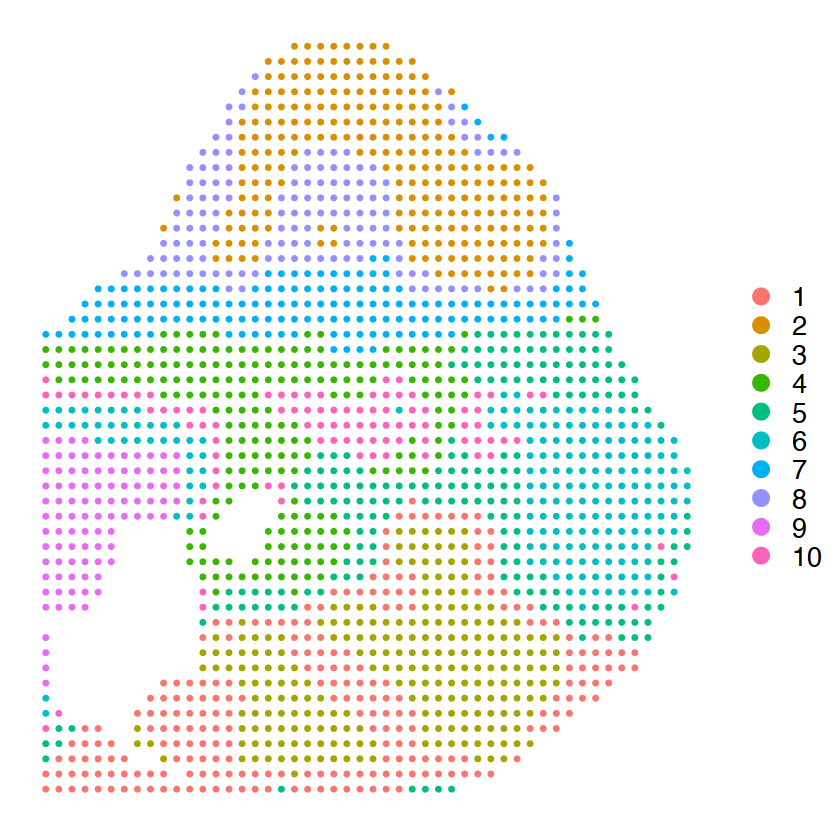

In [2]:
spamultivae.label <- as.numeric(readLines("louvain_clustering_labels.txt")) + 1
pos <- t(h5read("Multiomics_DBiT_seq_0713_data.h5", "pos"))
label.dat <- data.frame(pos, label=spamultivae.label, 
                        method="spaMultiVAE")
label.dat$label <- factor(label.dat$label, levels=1:10)

ggplot(label.dat, aes(x=X1, y=X2, color=label)) + geom_point(size=0.9) + 
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=20)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot denoised protein counts.

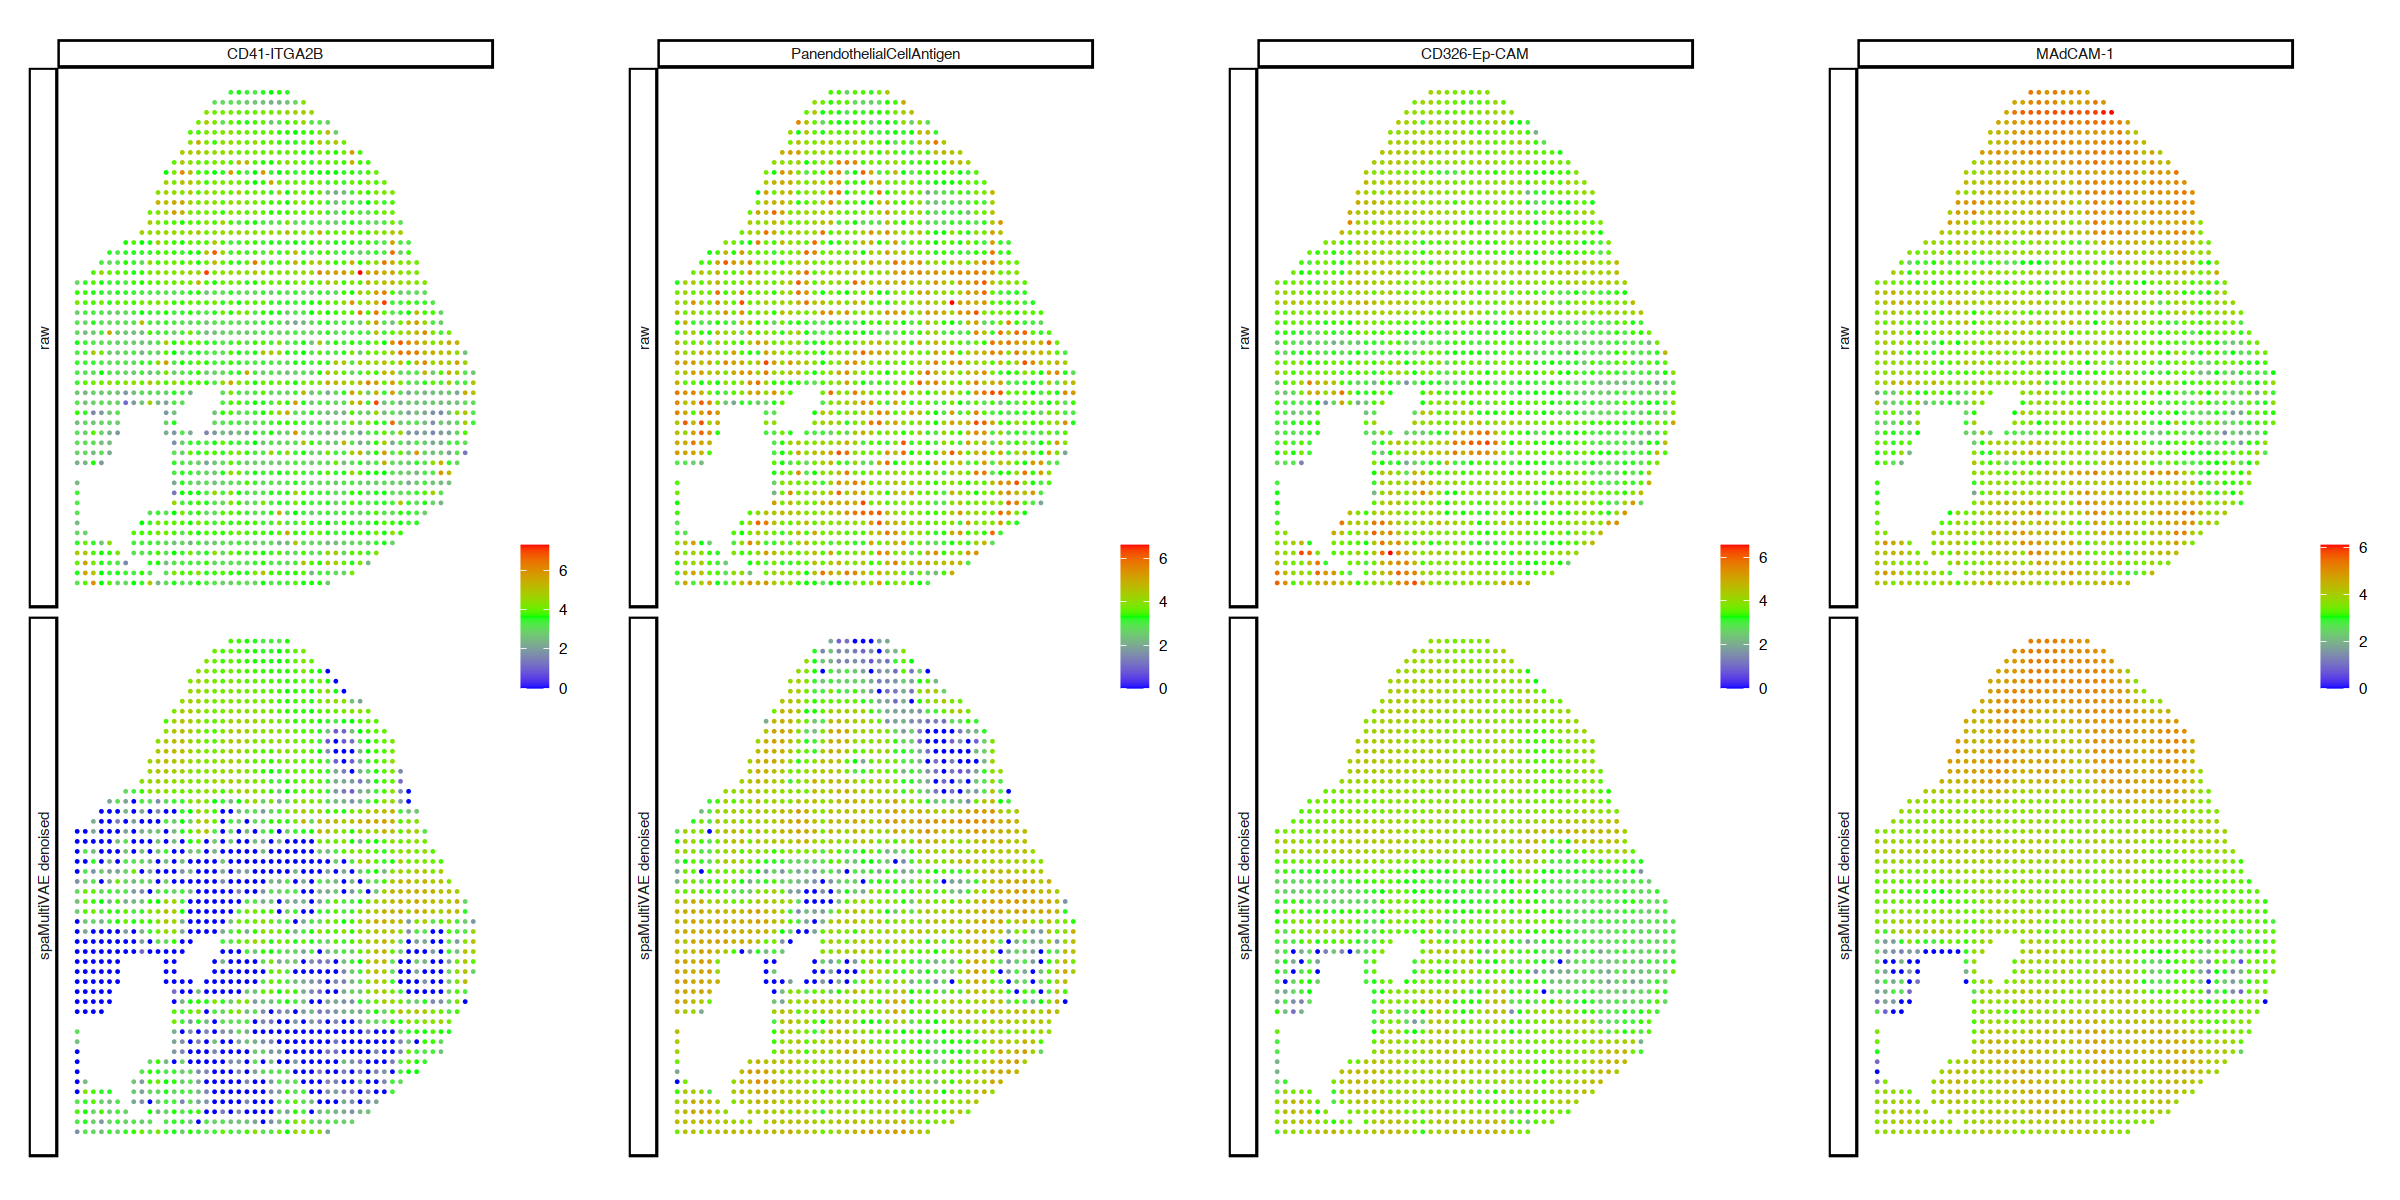

In [3]:
protein.name <- h5read("Multiomics_DBiT_seq_0713_data.h5", "protein")
raw.protein <- t(h5read("Multiomics_DBiT_seq_0713_data.h5", "X_protein"))
colnames(raw.protein) <- protein.name
lograwprotein <- log(raw.protein+1)

protein <- read.table("protein_denoised_counts.txt", sep=",")
colnames(protein) <- protein.name
logprotein <- log(protein+1)

protein.data <- data.frame(exp=c(logprotein[, "CD41-ITGA2B"], lograwprotein[, "CD41-ITGA2B"], 
                                 logprotein[, "PanendothelialCellAntigen"], lograwprotein[, "PanendothelialCellAntigen"], 
                                 logprotein[, "CD326-Ep-CAM"], lograwprotein[, "CD326-Ep-CAM"], 
                                 logprotein[, "MAdCAM-1"], lograwprotein[, "MAdCAM-1"]),
                           gene=rep(c("CD41-ITGA2B", "PanendothelialCellAntigen", "CD326-Ep-CAM", "MAdCAM-1"), each=2*nrow(pos)),
                           data=rep(rep(c("spaMultiVAE denoised", "raw"), each=nrow(pos)), 4),
                           x=rep(pos[,1], 8), y=rep(pos[,2], 8))
protein.data$gene <- factor(protein.data$gene, levels=c("CD41-ITGA2B", "PanendothelialCellAntigen", "CD326-Ep-CAM", "MAdCAM-1"))

p1 <- ggplot(protein.data[protein.data$gene=="CD41-ITGA2B",], aes(x=x, y=y, color=exp)) + geom_point(size=0.3) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD41-ITGA2B","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p2 <- ggplot(protein.data[protein.data$gene=="PanendothelialCellAntigen",], aes(x=x, y=y, color=exp)) + geom_point(size=0.3) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="PanendothelialCellAntigen","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p3 <- ggplot(protein.data[protein.data$gene=="CD326-Ep-CAM",], aes(x=x, y=y, color=exp)) + geom_point(size=0.3) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD326-Ep-CAM","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p4 <- ggplot(protein.data[protein.data$gene=="MAdCAM-1",], aes(x=x, y=y, color=exp)) + geom_point(size=0.3) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="MAdCAM-1","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

options(repr.plot.width=20, repr.plot.height=10)
plot_grid(p1, p2, p3, p4, scale=0.95, nrow=1)